## Argument Mining Practical Session

## PART I - tf-idf

To use this on Colab, run the following cells. (Authentication required).

**IMPORTANT**: the folder `share` exists on **my** Google Drive. Make sure to change this with a folder of your choice on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Folder `share` exists on my Google Drive. I navigate to this folder to store there the data.

In [ ]:
%cd gdrive/MyDrive/share

/content/gdrive/MyDrive/share


In [ ]:
! ls

abstrct  glove.6B.zip


Now we are cloning the Dataset into our Google Drive (in the folder specified earlier)

In [ ]:
! git clone https://gitlab.com/tomaye/abstrct.git

Cloning into 'abstrct'...
remote: Enumerating objects: 1369, done.
remote: Counting objects: 100% (1369/1369), done.
remote: Compressing objects: 100% (1365/1365), done.
remote: Total 1369 (delta 5), reused 1353 (delta 0), pack-reused 0
Receiving objects: 100% (1369/1369), 1.11 MiB | 3.18 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (1406/1406), done.


In [ ]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
! ls

abstrct  glove.6B.zip


We're good to go.

## Argumentative vs Non Argumentative Classification

**IMPORTANT** If you run locally (NOT COLAB) start from here.

Let's begin with some imports...

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import movie_reviews, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os
import re

In [ ]:
nltk.download('book')

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package dependency_treebank is already up-to-date!
[nltk_data]    | Downloadi

True

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [ ]:
fname = './abstrct/AbstRCT_corpus/data/train/neoplasm_train/10561201.txt'
annot = './abstrct/AbstRCT_corpus/data/train/neoplasm_train/10561201.ann'

In [ ]:
raw = [line for line in open(fname, 'r')][0]
raw

' A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer. The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL). Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone. Those who received prednisone alone could have mitoxantrone added after 6 weeks if there was no improvement in pain. HQL was assessed before treatment initiation and then every 3 weeks using the European Organization for Research and Treatment of Cancer Quality-of-Life Questionnaire C30 (EORTC QLQ-C30) and the Quality of Life Module-Prostate 14 (QOLM-P14), a trial-specific module developed for this study. An intent-to-treat analysis was used to determine the mean duration of HQL improvement and differences in improvement duration between groups of patients. At 6 we

In [ ]:
words = raw.strip().split()
len(words)

290

In [ ]:
from collections import Counter

c = Counter(words)
c.most_common(5)

[('of', 14), ('in', 11), ('and', 11), ('prednisone', 10), ('the', 8)]

In [ ]:
d = dict(c.most_common(5))

<BarContainer object of 5 artists>

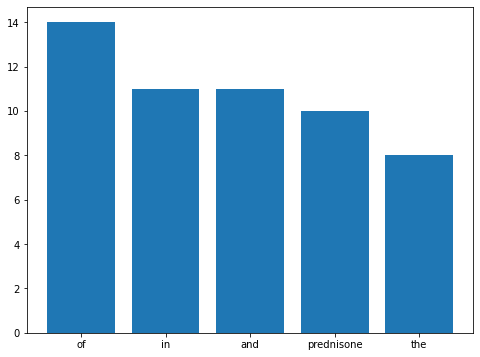

In [ ]:
plt.bar(d.keys(), d.values())

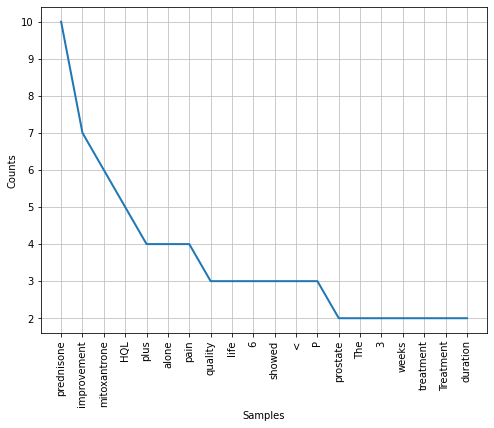

In [ ]:
cleaned = words[:]

for word in words:
  if word in stopwords.words('english'):
    cleaned.remove(word)

freq = nltk.FreqDist(cleaned)
freq.plot(20, cumulative=False)

In [ ]:
c = Counter(cleaned)
c.most_common(5)

[('prednisone', 10),
 ('improvement', 7),
 ('mitoxantrone', 6),
 ('HQL', 5),
 ('plus', 4)]

In [ ]:
sentences = raw.strip()

In [ ]:
sentences.split('.')

['A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer',
 ' The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL)',
 ' Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone',
 ' Those who received prednisone alone could have mitoxantrone added after 6 weeks if there was no improvement in pain',
 ' HQL was assessed before treatment initiation and then every 3 weeks using the European Organization for Research and Treatment of Cancer Quality-of-Life Questionnaire C30 (EORTC QLQ-C30) and the Quality of Life Module-Prostate 14 (QOLM-P14), a trial-specific module developed for this study',
 ' An intent-to-treat analysis was used to determine the mean duration of HQL improvement and differences in improvement duration between groups 

In [ ]:
sentences = nltk.sent_tokenize(raw.strip())
for s in sentences:
  print(s)
  print()

len(sentences)

A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.

The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL).

Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone.

Those who received prednisone alone could have mitoxantrone added after 6 weeks if there was no improvement in pain.

HQL was assessed before treatment initiation and then every 3 weeks using the European Organization for Research and Treatment of Cancer Quality-of-Life Questionnaire C30 (EORTC QLQ-C30) and the Quality of Life Module-Prostate 14 (QOLM-P14), a trial-specific module developed for this study.

An intent-to-treat analysis was used to determine the mean duration of HQL improvement and differences in improvement duration between groups of patients.

At 

11

In [ ]:
annotated = []
with open(annot, 'r') as infile:
  r = infile.readlines()
  for row in r:
    if re.match('^T\d', row):
      annotated.append(row.strip().split('\t'))

for i in annotated:
  print(i)

len(annotated)

['T1', 'MajorClaim 1 162', 'A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.']
['T2', 'Premise 992 1058', 'At 6 weeks, both groups showed improvement in several HQL domains,']
['T3', 'Premise 1063 1187', 'only physical functioning and pain were better in the mitoxantrone-plus-prednisone group than in the prednisone-alone group.']
['T4', 'Premise 1188 1447', 'After 6 weeks, patients taking prednisone showed no improvement in HQL scores, whereas those taking mitoxantrone plus prednisone showed significant improvements in global quality of life (P =.009), four functioning domains, and nine symptoms (.001 < P <. 01),']
['T6', 'Premise 1452 1568', 'the improvement (> 10 units on a scale of 0 to100) lasted longer than in the prednisone-alone group (.004 < P <.05).']
['T7', 'Premise 1569 1768', 'The addition of mitoxantrone to prednisone after failure of prednisone alone was associ

7

In [ ]:
def cosine_similarity(sent1, sent2):
  """
  1 - collect all the words of the 2 sentences
  2 - create 2 vectors (one for each sentence)
  3 - calculate the cosine of the angle between the 2 vectors
  """
  first = nltk.word_tokenize(sent1)
  second = nltk.word_tokenize(sent2)
  l1 = []
  l2 = []
  x = { w for w in first if w not in stopwords.words('english')}
  y = { w for w in second if w not in stopwords.words('english')}
  
  rvector = x.union(y)
  l1 = [1 if w in x else 0 for w in rvector]
  l2 = [1 if w in y else 0 for w in rvector]
  
  c = 0
  for i in range(len(rvector)):
    c += l1[i] * l2[i]
  
  cosine = c / float((sum(l1) * sum(l2)) ** 0.5)
  return cosine


In [ ]:
s1 = "hello world"
s2 = "hello world it's me"
print(cosine_similarity(s1, s2))

0.8164965809277261


In [ ]:
# tell the 7 arguments out of the 11 sentences in raw
for sent1 in sentences:
  match = ''
  similarity = 0
  for annotation in annotated:
    sent2 = annotation[2]
    cs = cosine_similarity(sent1, sent2)
    if cs > similarity:
      similarity = cs
      match = sent2
  
  print(f'ORIG {sent1}')
  print()
  print(f'ANN {match}')
  print()
  print(f'SIM = {similarity}')
  print('------')


ORIG A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.

ANN A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hormone-resistant, prostate cancer.

SIM = 1.0
------
ORIG The purpose of this study was to assess the effects of these treatments on health-related quality of life (HQL).

ANN The addition of mitoxantrone to prednisone after failure of prednisone alone was associated with improvements in pain, pain impact, pain relief, insomnia, and global quality of life (.001 < P <.003).

SIM = 0.34698895917974415
------
ORIG Men with metastatic prostate cancer (n = 161) were randomized to receive either daily prednisone alone or mitoxantrone (every 3 weeks) plus prednisone.

ANN A combination of mitoxantrone plus prednisone is preferable to prednisone alone for reduction of pain in men with metastatic, hor

In [ ]:
!ls

abstrct		   glove.6B.200d.txt  glove.6B.50d.txt
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip


In [ ]:
datadir = './abstrct/AbstRCT_corpus/data/train/neoplasm_train'
testdir = './abstrct/AbstRCT_corpus/data/test/neoplasm_test'

train_raw_files = [f for f in os.listdir(datadir) if f.endswith('.txt')]  # len = 350
train_ann_files = [f for f in os.listdir(datadir) if f.endswith('.ann')]  # len = 350

test_raw_files = [f for f in os.listdir(testdir) if f.endswith('.txt')]   # len = 100
test_ann_files = [f for f in os.listdir(testdir) if f.endswith('.ann')]   # len = 100

In [ ]:
len(test_ann_files)

100

In [ ]:
# I want 2 dictionaries: {fname: raw_tdef extract_annotated(fpath):
def extract_annotated(fpath):
  res = []
  with open(fpath, 'r') as infile:
    r = infile.readlines()
    for row in r:
      if re.match('^T\d', row):
        arg_tag, annotation, text = row.strip().split('\t')
        fname = os.path.basename(fpath).replace('.ann', '')
        name = f'{fname}-{arg_tag}'
        is_arg = annotation.split()[0]
        res.append((name, is_arg, text))
  return res


In [ ]:
from collections import defaultdict

train_ann_dict = defaultdict(list) # 350
test_ann_dict = defaultdict(list)  # 100

for f in train_ann_files:
  fname = f.replace('.ann', '')
  filepath = os.path.join(datadir, f)
  train_ann_dict[fname] = extract_annotated(filepath)


for f in test_ann_files:
  fname = f.replace('.ann', '')
  filepath = os.path.join(testdir, f)
  test_ann_dict[fname] = extract_annotated(filepath)

In [ ]:
train_raw_dict = {}  # 350 files
test_raw_dict = {}   # 100 files

for f in train_raw_files:
  with open(os.path.join(datadir, f), 'r') as infile:
    train_raw_dict[f.replace('.txt', '')] = infile.read().strip()


for f in test_raw_files:
  with open(os.path.join(testdir, f), 'r') as infile:
    test_raw_dict[f.replace('.txt', '')] = infile.read().strip()  

In [ ]:
train_ann_dict['16294343']

[('16294343-T2',
  'Premise',
  'Participants completing the intervention demonstrated improvement in male overall distress (P < 0.01), male global sexual function (P < 0.0001), and female global sexual function (P < 0.05) at 3-month follow-up,'),
 ('16294343-T3',
  'Premise',
  'but regression toward baseline was noted at 6-month follow-up.'),
 ('16294343-T4',
  'Premise',
  'However, utilization of ED treatments increased from 31% at the time of study entry to 49% at the 6-month follow-up (P = 0.003).'),
 ('16294343-T5',
  'Claim',
  'The results of this brief pilot counseling intervention demonstrated significant gains in sexual function and satisfaction and increased utilization of treatments for ED.'),
 ('16294343-T6',
  'Claim',
  'However, modifications are needed in future randomized trials to reduce the rate of premature termination and to improve long-term maintenance of gains.')]

In [ ]:
def extract_sentences(raw_dict, ann_dict):
  data = []
  for fname, raw_text in raw_dict.items():
    sentences = nltk.sent_tokenize(raw_text.strip())   # from the raw text
    arguments = [x[1] for x in ann_dict[fname]]        # from the annotation
    annotated = [x[2] for x in ann_dict[fname]]        # from the annotation
    for sent1 in sentences:
      match = ''
      similarity = 0
      annotated_arg = ''
      for arg, sent2 in zip(arguments, annotated):
        cs = cosine_similarity(sent1, sent2)
        if cs > similarity and cs > 0.8:
          # it is a match!
          similarity = cs
          match = sent2
          annotated_arg = arg
          break
      if not match:
        is_argumentative = 0
      else:
        is_argumentative = 1

      data.append((sent1, is_argumentative, annotated_arg))
  
  return data


In [ ]:
train_data = extract_sentences(train_raw_dict, train_ann_dict)
test_data = extract_sentences(test_raw_dict, test_ann_dict)

In [ ]:
print(len(train_data))

4418


In [ ]:
print(len(test_data))

1258


In [ ]:
# train_data: [(sent, 0, 'Premise')....]
len(list(filter(lambda x: x[1] == 0, train_data)))  # how many sentences are labelled as NON ARGUMENTATIVE

2471

In [ ]:
train = pd.DataFrame(train_data, columns=['text', 'label', 'arg'])

In [ ]:
train['arg'].value_counts()

              2471
Premise       1318
Claim          572
MajorClaim      57
Name: arg, dtype: int64

In [ ]:
test = pd.DataFrame(test_data, columns=['text', 'label', 'arg'])

In [ ]:
test.head()

,text,label,arg
0,Data from experimental studies suggest that oc...,1,MajorClaim
1,"To assess the antitumour effect of octreotide,...",0,
2,"All patients, aged 59-75 years, were not liabl...",0,
3,"Six patients were enrolled, 4 of these treated...",0,
4,The patients treated with octreotide showed a ...,1,Premise


In [ ]:
def preprocess_text(text):
  tokeniser = RegexpTokenizer(r'\w+')
  tokens = tokeniser.tokenize(text)

  lemmatiser = WordNetLemmatizer()
  lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]

  keywords = [l for l in lemmas if l not in stopwords.words('english')]

  return keywords

In [ ]:
s = "Hello my name is Marco"

In [ ]:
preprocess_text(s)

['hello', 'name', 'marco']

In [ ]:
x_train, y_train = train['text'], train['label']
x_test, y_test = test['text'], test['label']

In [ ]:
x_test.shape

(1258,)

In [ ]:
y_train.value_counts()

0    2471
1    1947
Name: label, dtype: int64

In [ ]:
vectoriser = TfidfVectorizer(analyzer=preprocess_text)

In [ ]:
x_train_tfidf = vectoriser.fit_transform(x_train)
x_train_tfidf.shape

(4418, 5336)

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf_scores = cross_val_score(sgd_clf, x_train_tfidf, y_train, cv=5)

In [ ]:
print(f'mean accuracy: {sgd_clf_scores.mean()} +/- {sgd_clf_scores.std() * 2}')

mean accuracy: 0.801724120260527 +/- 0.026558634497802748


In [ ]:
sgd_clf_pred = cross_val_predict(sgd_clf, x_train_tfidf, y_train, cv=5)

In [ ]:
confusion_matrix(y_train, sgd_clf_pred)

array([[2062,  409],
       [ 467, 1480]])

In [ ]:
grid = {'fit_intercept': [True, False],
        'early_stopping': [True, False],
        'loss': ['hinge', 'log', 'squared_hinge'],
        'penalty': ['l2', 'l1', 'none']}

search = GridSearchCV(estimator=sgd_clf, param_grid=grid, cv=5)
search.fit(x_train_tfidf, y_train)
search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


{'early_stopping': False,
 'fit_intercept': True,
 'loss': 'log',
 'penalty': 'l1'}

In [ ]:
grid_sgd_clf_scores = cross_val_score(search.best_estimator_, x_train_tfidf, y_train, cv=5)
print(f'mean accuracy: {grid_sgd_clf_scores.mean()} +/- {grid_sgd_clf_scores.std() * 2}')

mean accuracy: 0.8239032401879648 +/- 0.024616239782555116


In [ ]:
pipe = Pipeline([('vectoriser', vectoriser),
                 ('classifier', search.best_estimator_)])

pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vectoriser',
                 TfidfVectorizer(analyzer=<function preprocess_text at 0x7f281ce83ae8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents...
                ('classifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=1000, n

In [ ]:
y_test_pred = pipe.predict(x_test)


In [ ]:
accuracy_score(y_test, y_test_pred)

0.8163751987281399

In [ ]:
confusion_matrix(y_test, y_test_pred)

array([[567, 103],
       [128, 460]])

In [ ]:
classification_report(y_test, y_test_pred, output_dict=True)

{'0': {'f1-score': 0.8307692307692307,
  'precision': 0.8158273381294964,
  'recall': 0.8462686567164179,
  'support': 670},
 '1': {'f1-score': 0.7993049522154648,
  'precision': 0.8170515097690941,
  'recall': 0.782312925170068,
  'support': 588},
 'accuracy': 0.8163751987281399,
 'macro avg': {'f1-score': 0.8150370914923477,
  'precision': 0.8164394239492953,
  'recall': 0.814290790943243,
  'support': 1258},
 'weighted avg': {'f1-score': 0.8160625568506182,
  'precision': 0.816399526463426,
  'recall': 0.8163751987281399,
  'support': 1258}}



1.   compare raw text and annotated text
2.   extract what was identified as argument
3.   0: non argumentative, 1: argumentative
4.   load all dataset into training and test
5.   preprocess all text -> tf-idf representation
6.   cross-validate a SVM classifier
7.   -> found the best.estimator_
8.   build the pipeline (tf-idf + svm)
9.   train the pipeline model on the training set
10.  test on testing set

11.  and now? How to use it?



In [ ]:
text = "Coronavirus disease 2019 (COVID-19) is an infectious disease caused by coronavirus-2 (SARS-CoV-2) that causes a severe acute respiratory syndrome, a characteristic hyperinflammatory response, vascular damage, microangiopathy, angiogenesis and widespread thrombosis. Four stages of COVID-19 have been identified: the first stage is characterised by upper respiratory tract infection; the second by the onset of dyspnoea and pneumonia; the third by a worsening clinical scenario dominated by a cytokine storm and the consequent hyperinflammatory state; and the fourth by death or recovery. Currently, no treatment can act specifically against the SARS-CoV-2 infection. Based on the pathological features and different clinical phases of COVID-19, particularly in patients with moderate to severe COVID-19, the classes of drugs used are antiviral agents, inflammation inhibitors/antirheumatic drugs, low molecular weight heparins, plasma, and hyperimmune immunoglobulins. During this emergency period of the COVID-19 outbreak, clinical researchers are using and testing a variety of possible treatments. Based on these premises, this review aims to discuss the most updated pharmacological treatments to effectively act against the SARS-CoV-2 infection and support researchers and clinicians in relation to any current and future developments in curing COVID-19 patients."

In [ ]:
sents = nltk.sent_tokenize(text)

In [ ]:
sents

['Coronavirus disease 2019 (COVID-19) is an infectious disease caused by coronavirus-2 (SARS-CoV-2) that causes a severe acute respiratory syndrome, a characteristic hyperinflammatory response, vascular damage, microangiopathy, angiogenesis and widespread thrombosis.',
 'Four stages of COVID-19 have been identified: the first stage is characterised by upper respiratory tract infection; the second by the onset of dyspnoea and pneumonia; the third by a worsening clinical scenario dominated by a cytokine storm and the consequent hyperinflammatory state; and the fourth by death or recovery.',
 'Currently, no treatment can act specifically against the SARS-CoV-2 infection.',
 'Based on the pathological features and different clinical phases of COVID-19, particularly in patients with moderate to severe COVID-19, the classes of drugs used are antiviral agents, inflammation inhibitors/antirheumatic drugs, low molecular weight heparins, plasma, and hyperimmune immunoglobulins.',
 'During this e

In [ ]:
x_text = pd.Series(sents, name='text')
x_text.shape

(6,)

In [ ]:
y_new = pipe.predict(x_text)

In [ ]:
y_new

array([0, 0, 0, 1, 0, 0])

In [ ]:
pd.concat([x_text, pd.Series(y_new, name='pred')], axis=1)

,text,pred
0,Coronavirus disease 2019 (COVID-19) is an infe...,0
1,Four stages of COVID-19 have been identified: ...,0
2,"Currently, no treatment can act specifically a...",0
3,Based on the pathological features and differe...,1
4,During this emergency period of the COVID-19 o...,0
5,"Based on these premises, this review aims to d...",0
